# Air bnb price prediction - AdaBoost

## Installing requirements

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import itertools
import time
from tqdm import tqdm
import csv

from sklearn.decomposition import PCA
from sklearn import model_selection

from sklearn.model_selection import GridSearchCV


## Data loading

In [ ]:
df_clean = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/train_airbnb_berlin_preprocessed_phase2.csv", sep=";")
df_clean.shape

(15268, 60)

## Train test split

In [ ]:
# We're taking the preprocessed dataset obtained in the KNN notebook
from sklearn.model_selection import train_test_split

X = df_clean.drop("Price",axis=1)
y = df_clean["Price"].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [ ]:
# loading imputed and scaled data

X_train_processed = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/X_train_processed_adaboost.csv",sep=";")
X_test_processed = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/X_test_processed_adaboost.csv",sep=";")

# AdaBoost

Warning: we'll be taking the default DecisionTreeRegressor estimator for the boosting, using AdaBoost in the context of GBDT.

## Missing value imputation & Scaling

Moving on, the strategy will be to make several versions of the processed data, so as to determine which type of processing yields the best results !

For imputing values, let's try two types of univariate imputation for now:
- mean
- median
- most frequent

For scaling:
- Minmax on every numeric data
- standard scaling on every numeric data

We're going to create the 6 pipelines that correspond to each combination:
- mn_minmax
- mdn_minmax
- mf_minmax
- mn_std
- mdn_std
- mf_std



### First approach

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Pipelines for numeric values

num_pipeline_mn_minmax = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mdn_minmax = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mf_minmax = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mn_std = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mdn_std = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mf_std = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler())
])

# Let's get the list of numerical features.
numeric_features = ['Host Since',
                    'Host Response Rate',
                    'Latitude',
                    'Longitude',
                    'Accomodates',
                    'Bathrooms',
                    'Bedrooms',
                    'Beds',
                    'Guests Included',
                    'Min Nights',
                    'Reviews',
                    'Overall Rating',
                    'Accuracy Rating',
                    'Cleanliness Rating',
                    'Checkin Rating',
                    'Communication Rating',
                    'Location Rating',
                    'Value Rating',
                    'Distance from barycenter'
                    ]

airbnb_data_transformer_1 = ColumnTransformer([
    ("num_mn_minmax", num_pipeline_mn_minmax, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_2 = ColumnTransformer([
    ("num_mdn_minmax", num_pipeline_mdn_minmax, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_3 = ColumnTransformer([
    ("num_mf_minmax", num_pipeline_mf_minmax, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_4 = ColumnTransformer([
    ("num_mn_std", num_pipeline_mn_std, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_5 = ColumnTransformer([
    ("num_mdn_std", num_pipeline_mdn_std, numeric_features)
],remainder="passthrough")
airbnb_data_transformer_6 = ColumnTransformer([
    ("num_mf_std", num_pipeline_mf_std, numeric_features)
],remainder="passthrough")



Now, out of these imputers and scalers, let's see which combination yields the best performance.

We'll keep parameters for KNN Regressor as identical (default), since we're trying to see which preprocessing technique seems best. Hyperparameter tuning will come later.

In [ ]:
from sklearn.metrics import mean_squared_error

def train_test_adaboost_regressor(X_train, y_train, X_test, y_test):
    '''Trains and test a AdaBoost regression model on the given training and test set.
    The function prints the RMSE of the predictions on the test set for each
    type of preprocessing (6 combinations to test in total).
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector  with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector  with the values of the target variable of the test instances.

    '''

    # Define the 6 types of full pipelines, combining the above preprocessors with KNN Regressor
    full_pipeline_1 = Pipeline([
      ("data_processing", airbnb_data_transformer_1),
      ("adaboost_regression", AdaBoostRegressor(random_state=42))
    ])
    full_pipeline_2 = Pipeline([
      ("data_processing", airbnb_data_transformer_2),
      ("adaboost_regression", AdaBoostRegressor(random_state=42))
    ])
    full_pipeline_3 = Pipeline([
      ("data_processing", airbnb_data_transformer_3),
      ("adaboost_regression", AdaBoostRegressor(random_state=42))
    ])
    full_pipeline_4 = Pipeline([
      ("data_processing", airbnb_data_transformer_4),
      ("adaboost_regression", AdaBoostRegressor(random_state=42))
    ])
    full_pipeline_5 = Pipeline([
      ("data_processing", airbnb_data_transformer_5),
      ("adaboost_regression", AdaBoostRegressor(random_state=42))
    ])
    full_pipeline_6 = Pipeline([
      ("data_processing", airbnb_data_transformer_6),
      ("adaboost_regression", AdaBoostRegressor(random_state=42))
    ])

    # Transform the training data and train the KNN regressor.
    full_pipeline_1.fit(X_train, y_train)
    full_pipeline_2.fit(X_train, y_train)
    full_pipeline_3.fit(X_train, y_train)
    full_pipeline_4.fit(X_train, y_train)
    full_pipeline_5.fit(X_train, y_train)
    full_pipeline_6.fit(X_train, y_train)

    # Test the knn regressor on the test data.
    predictions_1 = full_pipeline_1.predict(X_test)
    predictions_2 = full_pipeline_2.predict(X_test)
    predictions_3 = full_pipeline_3.predict(X_test)
    predictions_4 = full_pipeline_4.predict(X_test)
    predictions_5 = full_pipeline_5.predict(X_test)
    predictions_6 = full_pipeline_6.predict(X_test)

    # Compute the prediction error. 
    
    mse_1 =  mean_squared_error(y_test, predictions_1)
    mse_2 =  mean_squared_error(y_test, predictions_2)
    mse_3 =  mean_squared_error(y_test, predictions_3)
    mse_4 =  mean_squared_error(y_test, predictions_4)
    mse_5 =  mean_squared_error(y_test, predictions_5)
    mse_6 =  mean_squared_error(y_test, predictions_6)

    # Print the RMSE.
    print("The RMSE error using pipeline 1 is: ", np.sqrt(mse_1))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 2 is: ", np.sqrt(mse_2))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 3 is: ", np.sqrt(mse_3))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 4 is: ", np.sqrt(mse_4))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 5 is: ", np.sqrt(mse_5))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 6 is: ", np.sqrt(mse_6))
    print("--------------------------- \n")

In [ ]:
train_test_adaboost_regressor(X_train, y_train, X_test, y_test)

The RMSE error using pipeline 1 is:  56.09075738441672
--------------------------- 

The RMSE error using pipeline 2 is:  75.40566266516724
--------------------------- 

The RMSE error using pipeline 3 is:  91.06211793512078
--------------------------- 

The RMSE error using pipeline 4 is:  98.41660505682417
--------------------------- 

The RMSE error using pipeline 5 is:  101.27820812717557
--------------------------- 

The RMSE error using pipeline 6 is:  61.14220308100628
--------------------------- 



Clearly, the choice of imputation and scaling strategies has a huge influence on performance. Here, config 1 (mean imputation + minmax scaling) works best at a fixed random state.

Let's see what a mix of min-max + std scaling gives.

### 2nd approach

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Pipelines for numeric values

num_pipeline_mn_minmax = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mn_std = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mdn_minmax = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mdn_std = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mf_minmax = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mf_std = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler())
])


# Let's get the list of numerical features that seem to have a Gaussian distribution
numeric_features_gaussian = ['Host Since',
                    'Latitude',
                    'Longitude',
                    'Distance from barycenter'
                    ]

# And the remaining which will be processed by Min-max scaling.
numeric_features_nongaussian = [f for f in numeric_features if f not in numeric_features_gaussian]

airbnb_data_transformer_7 = ColumnTransformer([
    ("num_mn_minmax", num_pipeline_mn_minmax, numeric_features_nongaussian),
    ("num_mn_std", num_pipeline_mn_std, numeric_features_gaussian)
],remainder="passthrough")

airbnb_data_transformer_8 = ColumnTransformer([
    ("num_mdn_minmax", num_pipeline_mdn_minmax, numeric_features_nongaussian),
    ("num_mdn_std", num_pipeline_mdn_std, numeric_features_gaussian)
],remainder="passthrough")

airbnb_data_transformer_9 = ColumnTransformer([
    ("num_mf_minmax", num_pipeline_mf_minmax, numeric_features_nongaussian),
    ("num_mf_std", num_pipeline_mf_std, numeric_features_gaussian)
],remainder="passthrough")




In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def train_test_adaboost_regressor_2(X_train, y_train, X_test, y_test):
    '''Trains and test a AdaBoost regression model on the given training and test set.
    The function prints the RMSE of the predictions on the test set for each
    type of preprocessing (3 combinations to test in total).
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector  with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector  with the values of the target variable of the test instances.

    '''

    # Define the full pipeline, combining the above preprocessors with KNN Regressor
    full_pipeline_7 = Pipeline([
      ("data_processing", airbnb_data_transformer_7),
      ("knn_regression", AdaBoostRegressor(random_state=42))
    ])
    full_pipeline_8 = Pipeline([
      ("data_processing", airbnb_data_transformer_8),
      ("knn_regression", AdaBoostRegressor(random_state=42))
    ])
    full_pipeline_9 = Pipeline([
      ("data_processing", airbnb_data_transformer_9),
      ("knn_regression", AdaBoostRegressor(random_state=42))
    ])

    # Transform the training data and train the KNN regressor.
    full_pipeline_7.fit(X_train, y_train)
    full_pipeline_8.fit(X_train, y_train)
    full_pipeline_9.fit(X_train, y_train)

    # Test the knn regressor on the test data.
    predictions_7 = full_pipeline_7.predict(X_test)
    predictions_8 = full_pipeline_8.predict(X_test)
    predictions_9 = full_pipeline_9.predict(X_test)

    # Compute the prediction error.
    mse_7 = mean_squared_error(y_test, predictions_7)
    mse_8 = mean_squared_error(y_test, predictions_8)
    mse_9 = mean_squared_error(y_test, predictions_9)

    # Print the RMSE.
    print("The RMSE error using pipeline 7 is: ", np.sqrt(mse_7))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 8 is: ", np.sqrt(mse_8))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 9 is: ", np.sqrt(mse_9))
    print("--------------------------- \n")

In [ ]:
train_test_adaboost_regressor_2(X_train, y_train, X_test, y_test)

The RMSE error using pipeline 7 is:  61.698457763603095
--------------------------- 

The RMSE error using pipeline 8 is:  87.96248476316474
--------------------------- 

The RMSE error using pipeline 9 is:  73.77289689007213
--------------------------- 



Most effective is with the median imputation, but still the results aren't that good.

Let's try one final combinations which is by removing distance from barycenter as one of the features.

### 3rd approach

In [ ]:

# Let's get the list of numerical features that seem to have a Gaussian distribution
numeric_features_gaussian = ['Host Since',
                    'Latitude',
                    'Longitude',
                    ]

# And the remaining which will be processed by Min-max scaling.
numeric_features_nongaussian = [f for f in numeric_features if f not in numeric_features_gaussian]

airbnb_data_transformer_10 = ColumnTransformer([
    ("num_mn_minmax", num_pipeline_mn_minmax, numeric_features_nongaussian),
    ("num_mn_std", num_pipeline_mn_std, numeric_features_gaussian)
],remainder="passthrough")

airbnb_data_transformer_11 = ColumnTransformer([
    ("num_mdn_minmax", num_pipeline_mdn_minmax, numeric_features_nongaussian),
    ("num_mdn_std", num_pipeline_mdn_std, numeric_features_gaussian)
],remainder="passthrough")

airbnb_data_transformer_12 = ColumnTransformer([
    ("num_mf_minmax", num_pipeline_mf_minmax, numeric_features_nongaussian),
    ("num_mf_std", num_pipeline_mf_std, numeric_features_gaussian)
],remainder="passthrough")




In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def train_test_adaboost_regressor_3(X_train, y_train, X_test, y_test):
    '''Trains and test a AdaBoost regression model on the given training and test set.
    The function prints the RMSE of the predictions on the test set for each
    type of preprocessing (3 combinations to test in total).
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector  with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector  with the values of the target variable of the test instances.

    '''

    # Define the full pipeline, combining the above preprocessors with KNN Regressor
    full_pipeline_10 = Pipeline([
      ("data_processing", airbnb_data_transformer_10),
      ("knn_regression", AdaBoostRegressor(random_state=42))
    ])
    full_pipeline_11 = Pipeline([
      ("data_processing", airbnb_data_transformer_11),
      ("knn_regression", AdaBoostRegressor(random_state=42))
    ])
    full_pipeline_12 = Pipeline([
      ("data_processing", airbnb_data_transformer_12),
      ("knn_regression", AdaBoostRegressor(random_state=42))
    ])

    # Transform the training data and train the KNN regressor.
    full_pipeline_10.fit(X_train, y_train)
    full_pipeline_11.fit(X_train, y_train)
    full_pipeline_12.fit(X_train, y_train)

    # Test the knn regressor on the test data.
    predictions_10 = full_pipeline_10.predict(X_test)
    predictions_11 = full_pipeline_11.predict(X_test)
    predictions_12 = full_pipeline_12.predict(X_test)

    # Compute the prediction error.
    mse_10 = mean_squared_error(y_test, predictions_10)
    mse_11 = mean_squared_error(y_test, predictions_11)
    mse_12 = mean_squared_error(y_test, predictions_12)

    # Print the RMSE.
    print("The RMSE error using pipeline 10 is: ", np.sqrt(mse_10))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 11 is: ", np.sqrt(mse_11))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 12 is: ", np.sqrt(mse_12))
    print("--------------------------- \n")

In [ ]:
train_test_adaboost_regressor_3(X_train, y_train, X_test, y_test)

The RMSE error using pipeline 10 is:  56.05464064203076
--------------------------- 

The RMSE error using pipeline 11 is:  91.1653699656034
--------------------------- 

The RMSE error using pipeline 12 is:  60.81426604025722
--------------------------- 



We will go with strategy 10!

### Constructing processed dataset



In [ ]:
# Keeping the same imputation and scaling strategies as the ones chosen in phase 1.



numeric_features = ['Host Since',
                    'Host Response Rate',
                    'Latitude',
                    'Longitude',
                    'Accomodates',
                    'Bathrooms',
                    'Bedrooms',
                    'Beds',
                    'Guests Included',
                    'Min Nights',
                    'Reviews',
                    'Overall Rating',
                    'Accuracy Rating',
                    'Cleanliness Rating',
                    'Checkin Rating',
                    'Communication Rating',
                    'Location Rating',
                    'Value Rating',
                    'Distance from barycenter'
                    ]

numeric_features_gaussian = ['Host Since',
                    'Latitude',
                    'Longitude',
                    ]
numeric_features_nongaussian = [f for f in numeric_features if f not in numeric_features_gaussian]


airbnb_data_transformer_10 = ColumnTransformer([
    ("num_mn_minmax", num_pipeline_mn_minmax, numeric_features_nongaussian),
    ("num_mn_std", num_pipeline_mn_std, numeric_features_gaussian)
],remainder="passthrough")

categorical_features = [f for f in list(X_train.columns) if f not in numeric_features]

X_train_processed_arr = airbnb_data_transformer_10.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed_arr, 
                                 columns = numeric_features_nongaussian+numeric_features_gaussian+categorical_features)

X_test_processed_arr = airbnb_data_transformer_10.fit_transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed_arr, 
                                 columns = numeric_features_nongaussian+numeric_features_gaussian+categorical_features)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ab1ad9350>,
      dtype=object)

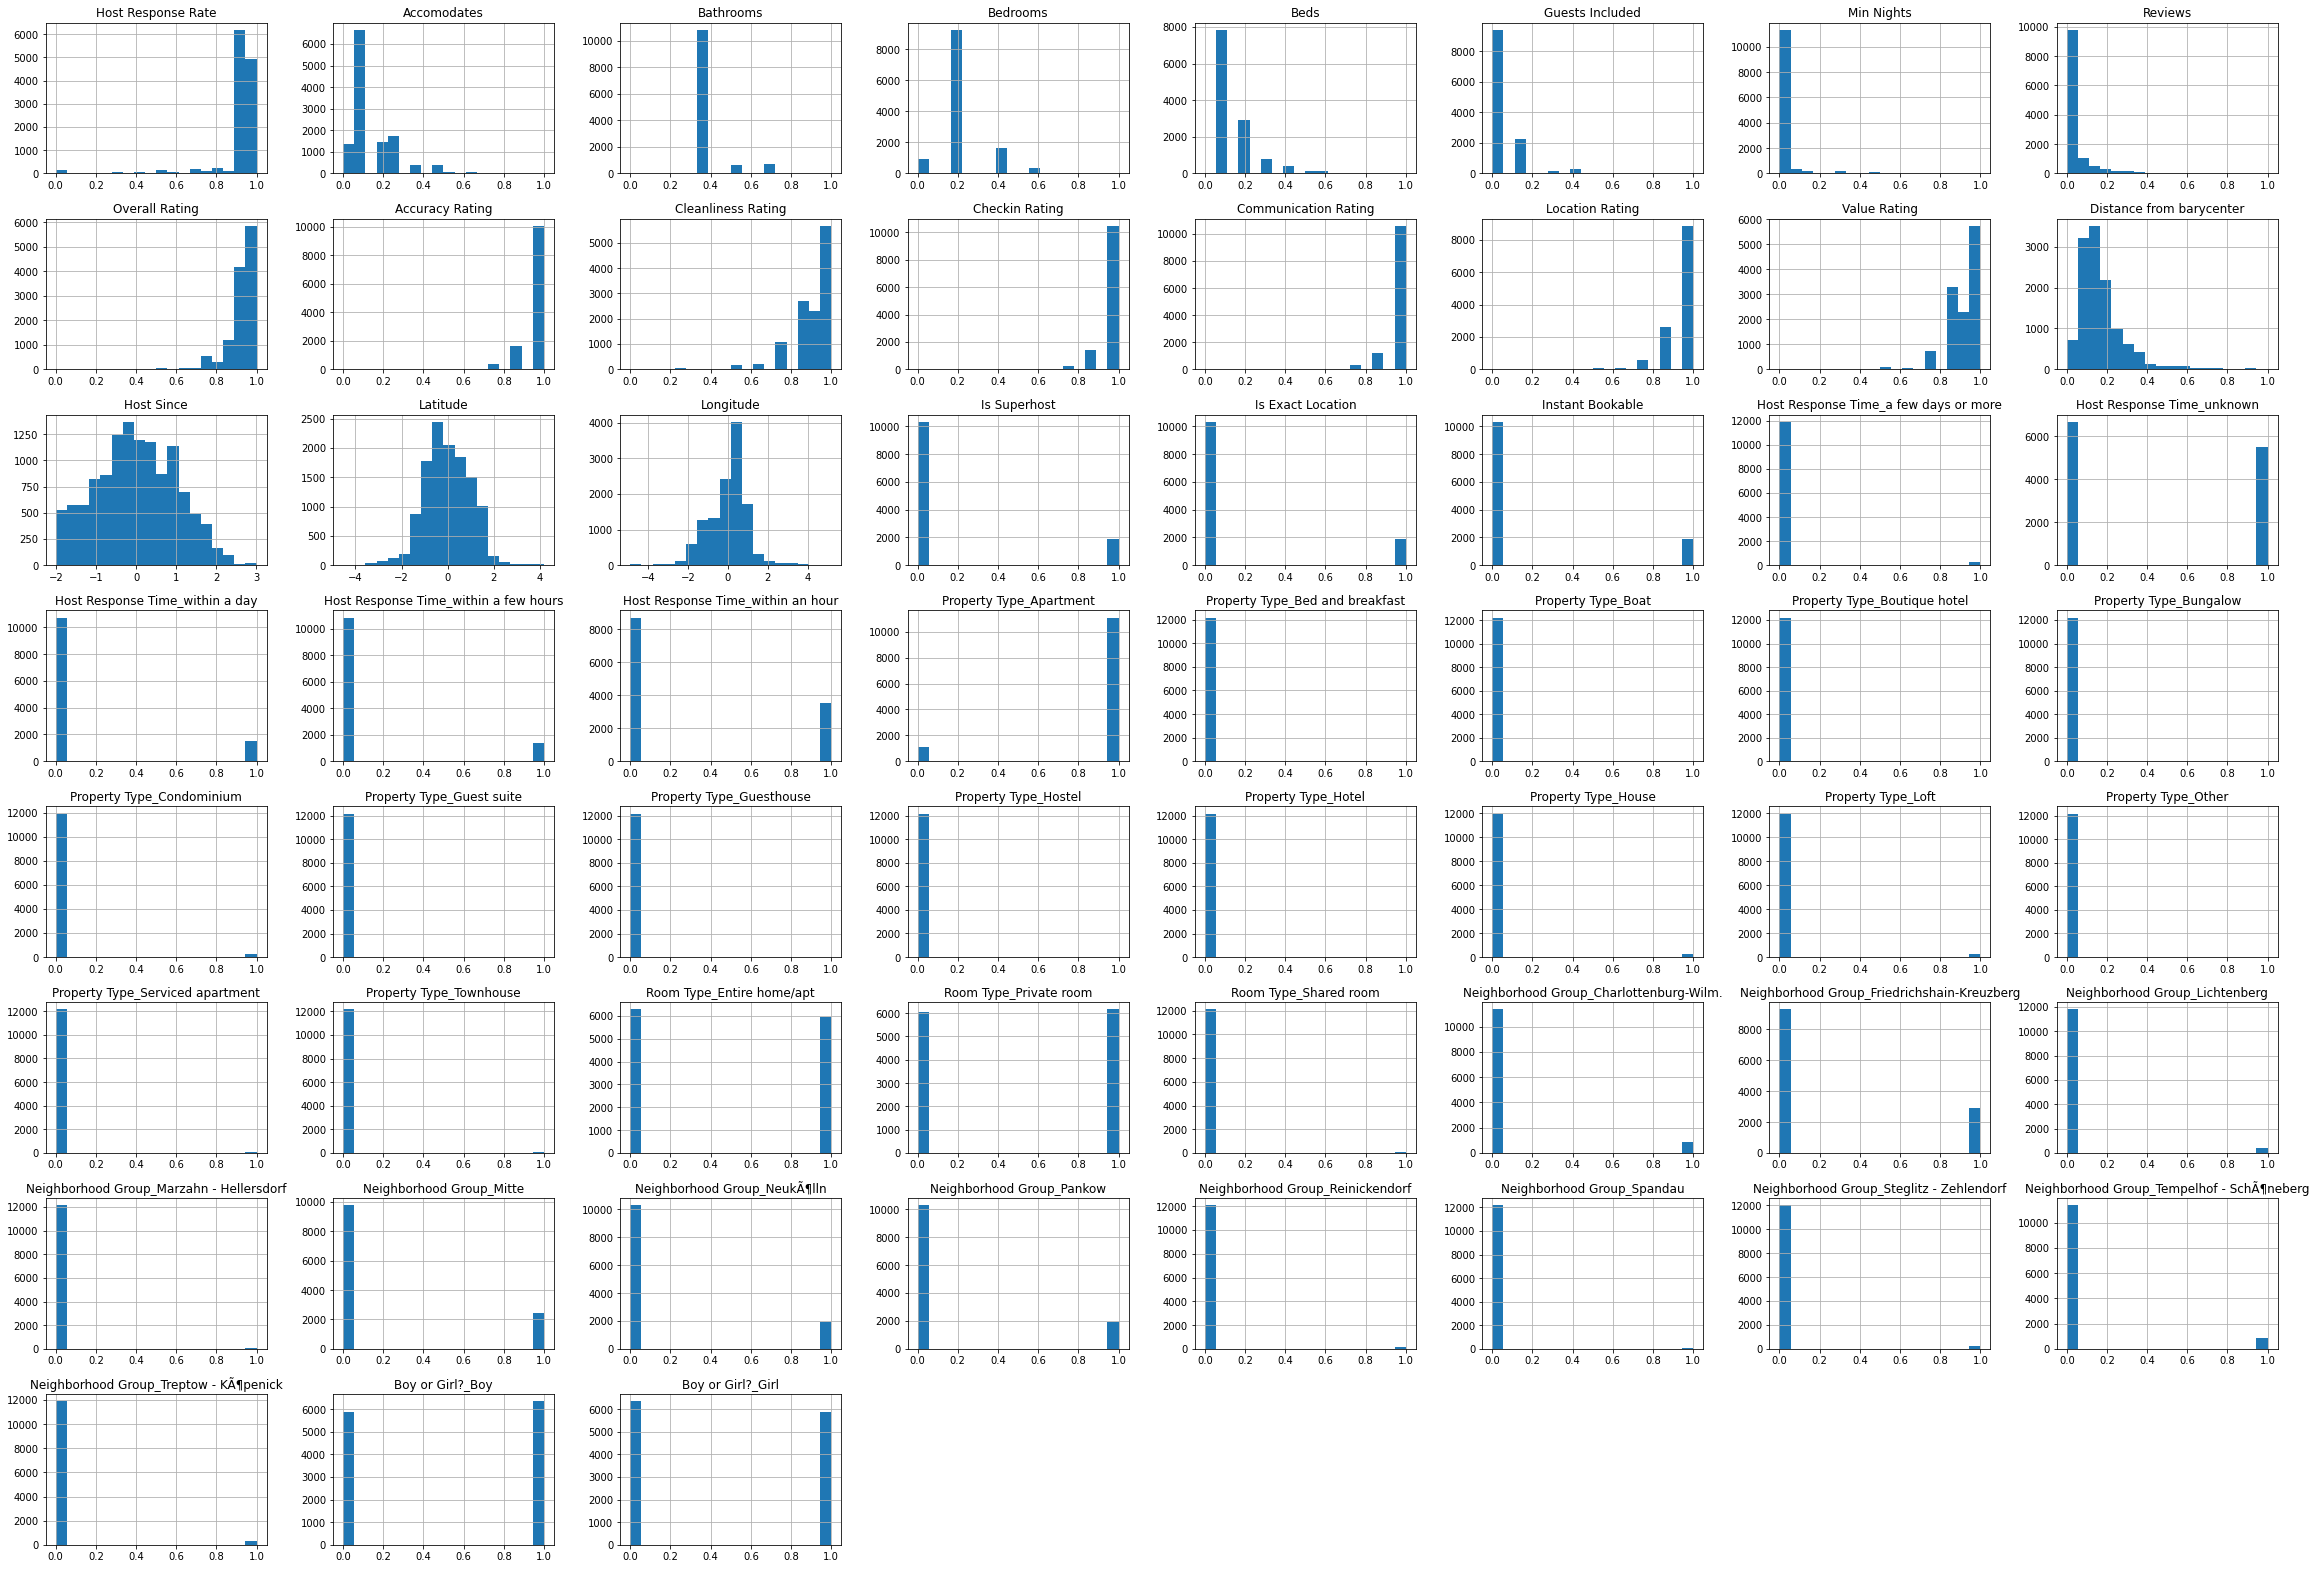

In [ ]:
X_train_processed.hist(figsize=(40,28),bins=18)

In [ ]:
X_train_processed.to_csv("/content/X_train_processed_adaboost.csv", sep=";", index=False)
#X_test_processed.to_csv("/content/X_test_processed_adaboost.csv", sep=";", index=False)

## Feature Selection

In [ ]:
# define processing function that given a combination of features, returns its MSE metric

from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline

knn = AdaBoostRegressor(random_state=42)
kf_10 = model_selection.KFold(n_splits=10,shuffle=True, random_state=1)

def processSubset(feature_set):
    score = -1*model_selection.cross_val_score(knn, X_train_processed[list(feature_set)], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    return {"model":list(feature_set), "MSE":score}

### Stepwise selection (forward)

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def forward(features):
    
    # Pull out features we still need to process
    remaining_features = [d for d in X_train_processed.columns if d not in features]

    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['MSE'].argmin()]
    
    toc = time.time()

    with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/forward_stepwise_selection_adaboost.csv","a") as file:
        writer = csv.writer(file,delimiter=';')
        data_row = [best_model.model,best_model.MSE]
        writer.writerow(data_row)      

    print("Processed", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_fwd = pd.DataFrame(columns=["model","MSE"]) 

tic = time.time()
features = []
 
header = ["feature set", "MSE"]
with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/forward_stepwise_selection_adaboost.csv","w") as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(header)

for i in tqdm(range(1,len(X_train_processed.columns)+1)):    
    models_fwd.loc[i] = forward(features)
    features = models_fwd.loc[i]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

  2%|▏         | 1/59 [00:32<31:04, 32.15s/it]

Processed 59 models on 1 features in 32.14462327957153 seconds.
['Bedrooms']


  3%|▎         | 2/59 [01:05<31:07, 32.76s/it]

Processed 58 models on 2 features in 33.17081880569458 seconds.
['Bedrooms', 'Value Rating']


  5%|▌         | 3/59 [01:40<31:30, 33.75s/it]

Processed 57 models on 3 features in 34.92444849014282 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft']


  7%|▋         | 4/59 [02:15<31:17, 34.14s/it]

Processed 56 models on 4 features in 34.72565817832947 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln']


  8%|▊         | 5/59 [02:52<31:40, 35.20s/it]

Processed 55 models on 5 features in 37.07737851142883 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms']


 10%|█         | 6/59 [03:27<31:15, 35.38s/it]

Processed 54 models on 6 features in 35.7260217666626 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy']


 12%|█▏        | 7/59 [04:06<31:30, 36.35s/it]

Processed 53 models on 7 features in 38.318270683288574 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating']


 14%|█▎        | 8/59 [04:48<32:26, 38.17s/it]

Processed 52 models on 8 features in 42.04569625854492 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day']


 15%|█▌        | 9/59 [05:31<33:00, 39.61s/it]

Processed 51 models on 9 features in 42.773557901382446 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel']


 17%|█▋        | 10/59 [06:14<33:20, 40.82s/it]

Processed 50 models on 10 features in 43.50766134262085 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more']


 19%|█▊        | 11/59 [07:00<34:01, 42.53s/it]

Processed 49 models on 11 features in 46.41672396659851 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast']


 20%|██        | 12/59 [07:47<34:09, 43.60s/it]

Processed 48 models on 12 features in 46.03933119773865 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat']


 22%|██▏       | 13/59 [08:35<34:28, 44.97s/it]

Processed 47 models on 13 features in 48.083651065826416 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel']


 24%|██▎       | 14/59 [09:21<34:04, 45.42s/it]

Processed 46 models on 14 features in 46.47090435028076 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow']


 25%|██▌       | 15/59 [10:08<33:44, 46.01s/it]

Processed 45 models on 15 features in 47.37201499938965 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite']


 27%|██▋       | 16/59 [10:55<33:08, 46.25s/it]

Processed 44 models on 16 features in 46.79090642929077 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse']


 29%|██▉       | 17/59 [11:43<32:39, 46.65s/it]

Processed 43 models on 17 features in 47.5538432598114 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel']


 31%|███       | 18/59 [12:32<32:18, 47.29s/it]

Processed 42 models on 18 features in 48.78819727897644 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House']


 32%|███▏      | 19/59 [13:18<31:25, 47.14s/it]

Processed 41 models on 19 features in 46.76883673667908 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other']


 34%|███▍      | 20/59 [14:06<30:44, 47.30s/it]

Processed 40 models on 20 features in 47.64482831954956 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse']


 36%|███▌      | 21/59 [14:53<29:56, 47.28s/it]

Processed 39 models on 21 features in 47.23158240318298 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room']


 37%|███▋      | 22/59 [15:41<29:16, 47.48s/it]

Processed 38 models on 22 features in 47.932326316833496 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg']


 39%|███▉      | 23/59 [16:30<28:47, 47.97s/it]

Processed 37 models on 23 features in 49.12038445472717 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf']


 41%|████      | 24/59 [17:18<27:51, 47.74s/it]

Processed 36 models on 24 features in 47.1983757019043 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf']


 42%|████▏     | 25/59 [18:05<27:01, 47.70s/it]

Processed 35 models on 25 features in 47.571582078933716 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau']


 44%|████▍     | 26/59 [18:52<26:04, 47.41s/it]

Processed 34 models on 26 features in 46.70987677574158 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf']


 46%|████▌     | 27/59 [19:39<25:16, 47.39s/it]

Processed 33 models on 27 features in 47.33258867263794 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick']


 47%|████▋     | 28/59 [20:25<24:17, 47.02s/it]

Processed 32 models on 28 features in 46.154250621795654 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl']


 49%|████▉     | 29/59 [21:12<23:22, 46.75s/it]

Processed 31 models on 29 features in 46.1175696849823 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours']


 51%|█████     | 30/59 [21:57<22:27, 46.48s/it]

Processed 30 models on 30 features in 45.83288645744324 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost']


 53%|█████▎    | 31/59 [22:39<21:04, 45.16s/it]

Processed 29 models on 31 features in 42.0590078830719 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location']


 54%|█████▍    | 32/59 [23:23<20:06, 44.68s/it]

Processed 28 models on 32 features in 43.536269187927246 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable']


 56%|█████▌    | 33/59 [24:04<18:55, 43.68s/it]

Processed 27 models on 33 features in 41.33368635177612 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg']


 58%|█████▊    | 34/59 [24:44<17:43, 42.53s/it]

Processed 26 models on 34 features in 39.840272426605225 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhoo

 59%|█████▉    | 35/59 [25:23<16:36, 41.51s/it]

Processed 25 models on 35 features in 39.09913516044617 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 61%|██████    | 36/59 [26:04<15:46, 41.14s/it]

Processed 24 models on 36 features in 40.2785165309906 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood 

 63%|██████▎   | 37/59 [26:43<14:51, 40.53s/it]

Processed 23 models on 37 features in 39.08982706069946 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 64%|██████▍   | 38/59 [27:27<14:32, 41.54s/it]

Processed 22 models on 38 features in 43.86781978607178 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 66%|██████▌   | 39/59 [28:08<13:49, 41.48s/it]

Processed 21 models on 39 features in 41.324350118637085 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhoo

 68%|██████▊   | 40/59 [28:50<13:10, 41.59s/it]

Processed 20 models on 40 features in 41.850212812423706 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhoo

 69%|██████▉   | 41/59 [29:28<12:11, 40.65s/it]

Processed 19 models on 41 features in 38.42974615097046 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 71%|███████   | 42/59 [30:05<11:10, 39.47s/it]

Processed 18 models on 42 features in 36.7020537853241 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood 

 73%|███████▎  | 43/59 [30:39<10:03, 37.71s/it]

Processed 17 models on 43 features in 33.59381628036499 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 75%|███████▍  | 44/59 [31:14<09:14, 36.99s/it]

Processed 16 models on 44 features in 35.28860902786255 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 76%|███████▋  | 45/59 [31:45<08:15, 35.36s/it]

Processed 15 models on 45 features in 31.569044589996338 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhoo

 78%|███████▊  | 46/59 [32:16<07:21, 33.93s/it]

Processed 14 models on 46 features in 30.58511519432068 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 80%|███████▉  | 47/59 [32:46<06:31, 32.63s/it]

Processed 13 models on 47 features in 29.59106755256653 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 81%|████████▏ | 48/59 [33:15<05:47, 31.55s/it]

Processed 12 models on 48 features in 28.9974582195282 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood 

 83%|████████▎ | 49/59 [33:48<05:20, 32.06s/it]

Processed 11 models on 49 features in 33.25891637802124 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 85%|████████▍ | 50/59 [34:27<05:06, 34.10s/it]

Processed 10 models on 50 features in 38.84872794151306 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 86%|████████▋ | 51/59 [35:05<04:43, 35.46s/it]

Processed 9 models on 51 features in 38.598010540008545 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 88%|████████▊ | 52/59 [35:43<04:12, 36.11s/it]

Processed 8 models on 52 features in 37.63585424423218 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood 

 90%|████████▉ | 53/59 [36:21<03:40, 36.77s/it]

Processed 7 models on 53 features in 38.29644250869751 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood 

 92%|█████████▏| 54/59 [36:55<02:59, 35.86s/it]

Processed 6 models on 54 features in 33.734360218048096 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 93%|█████████▎| 55/59 [37:27<02:19, 34.78s/it]

Processed 5 models on 55 features in 32.24770498275757 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood 

 95%|█████████▍| 56/59 [37:56<01:39, 33.08s/it]

Processed 4 models on 56 features in 29.110955238342285 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 97%|█████████▋| 57/59 [38:21<01:01, 30.63s/it]

Processed 3 models on 57 features in 24.888087034225464 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

 98%|█████████▊| 58/59 [38:41<00:27, 27.43s/it]

Processed 2 models on 58 features in 19.971389293670654 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

100%|██████████| 59/59 [38:52<00:00, 39.53s/it]

Processed 1 models on 59 features in 10.318323373794556 seconds.
['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood

In [ ]:
models_fwd.loc[models_fwd['MSE'].idxmin()].MSE

1879.1551849427083

In [ ]:
best_features_fwd = models_fwd.loc[models_fwd['MSE'].idxmin()]['model']
print(best_features_fwd,"\n",len(best_features_fwd))

['Bedrooms', 'Value Rating', 'Property Type_Loft', 'Neighborhood Group_NeukÃ¶lln', 'Bathrooms', 'Boy or Girl?_Boy', 'Overall Rating', 'Host Response Time_within a day', 'Property Type_Hotel', 'Host Response Time_a few days or more', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_House', 'Property Type_Other', 'Property Type_Townhouse', 'Room Type_Shared room', 'Neighborhood Group_Lichtenberg', 'Neighborhood Group_Marzahn - Hellersdorf', 'Neighborhood Group_Reinickendorf', 'Neighborhood Group_Spandau', 'Neighborhood Group_Steglitz - Zehlendorf', 'Neighborhood Group_Treptow - KÃ¶penick', 'Boy or Girl?_Girl', 'Host Response Time_within a few hours', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Neighborhood Group_Tempelhof - SchÃ¶neberg', 'Neighborhood Group_Charlottenburg-Wilm.', 'Accuracy Rating', 'Location Rating

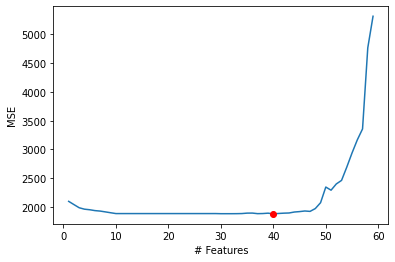

In [ ]:
import matplotlib.pyplot as plt

plt.plot(models_fwd["MSE"])
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(models_fwd["MSE"].idxmin(), models_fwd["MSE"].min(), "or")

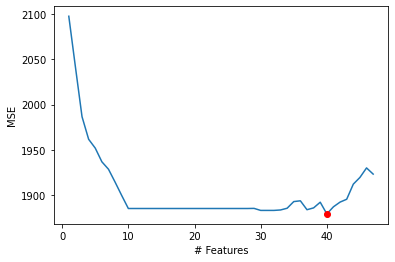

In [ ]:
import matplotlib.pyplot as plt

plt.plot(models_fwd["MSE"][:47])
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(models_fwd["MSE"].idxmin(), models_fwd["MSE"].min(), "or")

In [ ]:
models_fwd = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/forward_stepwise_selection_adaboost.csv", sep=';')
models_fwd

,feature set,MSE
0,['Bedrooms'],2097.513442
1,"['Bedrooms', 'Value Rating']",2041.587127
2,"['Bedrooms', 'Value Rating', 'Property Type_Lo...",1986.544536
3,"['Bedrooms', 'Value Rating', 'Property Type_Lo...",1961.604509
4,"['Bedrooms', 'Value Rating', 'Property Type_Lo...",1951.825398
5,"['Bedrooms', 'Value Rating', 'Property Type_Lo...",1936.727501
6,"['Bedrooms', 'Value Rating', 'Property Type_Lo...",1928.506301
7,"['Bedrooms', 'Value Rating', 'Property Type_Lo...",1914.249105
8,"['Bedrooms', 'Value Rating', 'Property Type_Lo...",1899.463380
9,"['Bedrooms', 'Value Rating', 'Property Type_Lo...",1885.137147


In [ ]:
best_features_fwd = eval(models_fwd.loc[models_fwd['MSE'].idxmin()]["feature set"])

In [ ]:
best_features_fwd

['Bedrooms',
 'Value Rating',
 'Property Type_Loft',
 'Neighborhood Group_NeukÃ¶lln',
 'Bathrooms',
 'Boy or Girl?_Boy',
 'Overall Rating',
 'Host Response Time_within a day',
 'Property Type_Hotel',
 'Host Response Time_a few days or more',
 'Property Type_Bed and breakfast',
 'Property Type_Boat',
 'Property Type_Boutique hotel',
 'Property Type_Bungalow',
 'Property Type_Guest suite',
 'Property Type_Guesthouse',
 'Property Type_Hostel',
 'Property Type_House',
 'Property Type_Other',
 'Property Type_Townhouse',
 'Room Type_Shared room',
 'Neighborhood Group_Lichtenberg',
 'Neighborhood Group_Marzahn - Hellersdorf',
 'Neighborhood Group_Reinickendorf',
 'Neighborhood Group_Spandau',
 'Neighborhood Group_Steglitz - Zehlendorf',
 'Neighborhood Group_Treptow - KÃ¶penick',
 'Boy or Girl?_Girl',
 'Host Response Time_within a few hours',
 'Is Superhost',
 'Is Exact Location',
 'Instant Bookable',
 'Neighborhood Group_Tempelhof - SchÃ¶neberg',
 'Neighborhood Group_Charlottenburg-Wilm.',
 '

### Stepwise selection (backward)

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def backward(features):
    
    # Pull out features we still need to process

    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest MSE
    best_model = models.loc[models['MSE'].argmin()]
    
    toc = time.time()

    with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection_adaboost.csv","a") as file:
        writer = csv.writer(file,delimiter=';')
        data_row = [best_model.model,best_model.MSE]
        writer.writerow(data_row)      

    print("Processed", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_bwd = pd.DataFrame(columns=["model","MSE"], index=range(1,len(X_train_processed.columns))) 

tic = time.time()
features = X_train_processed.columns
 
header = ["feature set", "MSE"]
with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection.csv_adaboost","w") as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(header)

while(len(features)>1):    
    models_bwd.loc[len(features)-1] = backward(features)
    features = models_bwd.loc[len(features)-1]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 59 models on 58 features in 619.6188917160034 seconds.
['Host Response Rate', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Min Nights', 'Reviews', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating', 'Distance from barycenter', 'Host Since', 'Latitude', 'Longitude', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Host Response Time_a few days or more', 'Host Response Time_unknown', 'Host Response Time_within a day', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Apartment', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Condominium', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Hotel', 'Property Type_House', 'Property Type_Loft', 'Property Type_Other', 'Property Type_Serviced apartment

In [ ]:
models_bwd = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection_adaboost.csv", sep=';',names=["feature set","MSE"])

In [ ]:
models_bwd

,feature set,MSE
0,"['Host Response Rate', 'Accomodates', 'Bathroo...",3595.131919
1,"['Host Response Rate', 'Accomodates', 'Bathroo...",3656.649925
2,"['Host Response Rate', 'Accomodates', 'Bathroo...",2699.363476
3,"['Host Response Rate', 'Accomodates', 'Bathroo...",2603.461001
4,"['Host Response Rate', 'Accomodates', 'Bathroo...",2399.198151
5,"['Host Response Rate', 'Accomodates', 'Bathroo...",2291.986827
6,"['Host Response Rate', 'Accomodates', 'Bathroo...",2267.443399
7,"['Host Response Rate', 'Accomodates', 'Bathroo...",2148.915179
8,"['Host Response Rate', 'Accomodates', 'Bathroo...",2083.212623
9,"['Host Response Rate', 'Accomodates', 'Bathroo...",1989.543634


In [ ]:
best_features_bwd = eval(models_bwd.loc[models_bwd["MSE"].idxmin()]['feature set'])
len(best_features_bwd)

20

In [ ]:
best_features_bwd

['Bathrooms',
 'Beds',
 'Min Nights',
 'Overall Rating',
 'Accuracy Rating',
 'Communication Rating',
 'Value Rating',
 'Host Response Time_unknown',
 'Host Response Time_within a day',
 'Host Response Time_within an hour',
 'Property Type_Apartment',
 'Property Type_Condominium',
 'Property Type_Hostel',
 'Property Type_Hotel',
 'Property Type_Loft',
 'Property Type_Serviced apartment',
 'Room Type_Entire home/apt',
 'Room Type_Private room',
 'Neighborhood Group_Friedrichshain-Kreuzberg',
 'Neighborhood Group_NeukÃ¶lln']

In [ ]:
models_bwd["MSE"].min()

1864.801365486212

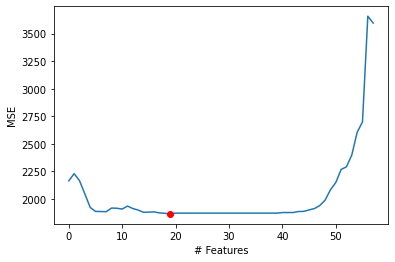

In [ ]:
import matplotlib.pyplot as plt

#when saving to pandas dataframe, order got inverted. We need to reorder.
plt.plot(list(models_bwd['MSE'].sort_index(ascending=False)))
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(57-models_bwd["MSE"].idxmin(), models_bwd["MSE"].min(), "or")

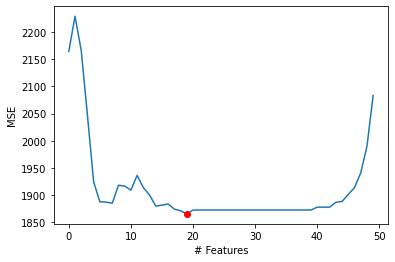

In [ ]:
import matplotlib.pyplot as plt

#when saving to pandas dataframe, order got inverted. We need to reorder.
plt.plot(list(models_bwd['MSE'].sort_index(ascending=False))[:50])
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(57-models_bwd["MSE"].idxmin(), models_bwd["MSE"].min(), "or")

### PCA

Here, it is difficult to implement PCA as the numerical values have not been standardized, but scaled min-max. PCA expects zero mean and unit standard deviation for the inputs, which is not the case.

We will go straight to hyperparameter tuning!

## Hyperparameter tuning

In [ ]:
len(best_features_bwd)

20

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
# Let's first decide on which loss to use


pgrid1 = {"loss":["linear","square","exponential"]}
adaboost = AdaBoostRegressor(random_state=42)

grid_search1 = GridSearchCV(adaboost,param_grid=pgrid1,cv=10, verbose=11)
grid_search1.fit(X_train_processed[best_features_bwd],y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV 1/10; 1/3] START loss=linear................................................
[CV 1/10; 1/3] END .................loss=linear;, score=0.132 total time=   0.1s
[CV 2/10; 1/3] START loss=linear................................................
[CV 2/10; 1/3] END .................loss=linear;, score=0.207 total time=   0.1s
[CV 3/10; 1/3] START loss=linear................................................
[CV 3/10; 1/3] END .................loss=linear;, score=0.086 total time=   0.1s
[CV 4/10; 1/3] START loss=linear................................................
[CV 4/10; 1/3] END .................loss=linear;, score=0.135 total time=   0.2s
[CV 5/10; 1/3] START loss=linear................................................
[CV 5/10; 1/3] END .................loss=linear;, score=0.204 total time=   0.1s
[CV 6/10; 1/3] START loss=linear................................................
[CV 6/10; 1/3] END .................loss=linear;

GridSearchCV(cv=10, estimator=AdaBoostRegressor(random_state=42),
             param_grid={'loss': ['linear', 'square', 'exponential']},
             verbose=11)

In [ ]:
print('Best loss function:', grid_search1.best_estimator_.get_params()['loss'])
print('Accuracy: ', grid_search1.best_score_ * 100)

Best loss function: linear
Accuracy:  15.794612152053716


Let's move on with linear loss for now.

In [ ]:
# Let's first decide on which learning rate and number of estimators to use

from sklearn.tree import DecisionTreeRegressor


pgrid2 = {"learning_rate": [0.001, 0.01, 1.0],
          "n_estimators": [50,100,150,200]}
adaboost = AdaBoostRegressor(random_state=42)

grid_search2 = GridSearchCV(adaboost,param_grid=pgrid2,cv=10, verbose=11)
grid_search2.fit(X_train_processed[best_features_bwd],y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV 1/10; 1/12] START learning_rate=0.001, n_estimators=50......................
[CV 1/10; 1/12] END learning_rate=0.001, n_estimators=50;, score=0.325 total time=   0.8s
[CV 2/10; 1/12] START learning_rate=0.001, n_estimators=50......................
[CV 2/10; 1/12] END learning_rate=0.001, n_estimators=50;, score=0.274 total time=   0.8s
[CV 3/10; 1/12] START learning_rate=0.001, n_estimators=50......................
[CV 3/10; 1/12] END learning_rate=0.001, n_estimators=50;, score=0.349 total time=   0.8s
[CV 4/10; 1/12] START learning_rate=0.001, n_estimators=50......................
[CV 4/10; 1/12] END learning_rate=0.001, n_estimators=50;, score=0.249 total time=   0.7s
[CV 5/10; 1/12] START learning_rate=0.001, n_estimators=50......................
[CV 5/10; 1/12] END learning_rate=0.001, n_estimators=50;, score=0.351 total time=   0.7s
[CV 6/10; 1/12] START learning_rate=0.001, n_estimators=50......................
[

GridSearchCV(cv=10, estimator=AdaBoostRegressor(random_state=42),
             param_grid={'learning_rate': [0.001, 0.01, 1.0],
                         'n_estimators': [50, 100, 150, 200]},
             verbose=11)

In [ ]:
print('Best learning rate:', grid_search2.best_estimator_.get_params()['learning_rate'])
print('Best number of estimators:', grid_search2.best_estimator_.get_params()['n_estimators'])

print('Accuracy: ', grid_search2.best_score_ * 100)

Best learning rate: 0.01
Best number of estimators: 50
Accuracy:  30.099454332430607


I realized just here maybe that tuning hyperparameters before hand might have been for effective.

In [ ]:
pgrid_raw = {"learning_rate": [0.001, 0.01, 1.0,10],
          "n_estimators": [25,35,50,100,150,200]}
adaboost = AdaBoostRegressor(random_state=42)

grid_search_raw = GridSearchCV(adaboost,param_grid=pgrid_raw,cv=10, verbose=11)
grid_search_raw.fit(X_train_processed,y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[CV 1/10; 1/24] END learning_rate=0.001, n_estimators=25;, score=0.346 total time=   1.2s
[CV 2/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[CV 2/10; 1/24] END learning_rate=0.001, n_estimators=25;, score=0.300 total time=   1.2s
[CV 3/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[CV 3/10; 1/24] END learning_rate=0.001, n_estimators=25;, score=0.405 total time=   1.1s
[CV 4/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[CV 4/10; 1/24] END learning_rate=0.001, n_estimators=25;, score=0.299 total time=   1.1s
[CV 5/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[CV 5/10; 1/24] END learning_rate=0.001, n_estimators=25;, score=0.365 total time=   1.1s
[CV 6/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[

GridSearchCV(cv=10, estimator=AdaBoostRegressor(random_state=42),
             param_grid={'learning_rate': [0.001, 0.01, 1.0, 10],
                         'n_estimators': [25, 35, 50, 100, 150, 200]},
             verbose=11)

In [ ]:
print('Best learning rate:', grid_search_raw.best_estimator_.get_params()['learning_rate'])
print('Best number of estimators:', grid_search_raw.best_estimator_.get_params()['n_estimators'])

print('Accuracy: ', grid_search_raw.best_score_ * 100)

Best learning rate: 0.001
Best number of estimators: 100
Accuracy:  33.58779487391956


Okay, here the initial parameters were not optimal for doing feature selection. Let's restart by setting an initial hyperparameter search.

# AdaBoost phase 2

## Initial hyperparameter search

In [ ]:
pgrid_raw = {"learning_rate": [0.001, 0.01, 1.0,10],
          "n_estimators": [25,35,50,100,150,200]}
adaboost = AdaBoostRegressor(random_state=42)

grid_search_raw = GridSearchCV(adaboost,param_grid=pgrid_raw,cv=10, verbose=11)
grid_search_raw.fit(X_train_processed,y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV 1/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[CV 1/10; 1/24] END learning_rate=0.001, n_estimators=25;, score=0.346 total time=   1.2s
[CV 2/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[CV 2/10; 1/24] END learning_rate=0.001, n_estimators=25;, score=0.300 total time=   1.2s
[CV 3/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[CV 3/10; 1/24] END learning_rate=0.001, n_estimators=25;, score=0.405 total time=   1.1s
[CV 4/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[CV 4/10; 1/24] END learning_rate=0.001, n_estimators=25;, score=0.299 total time=   1.1s
[CV 5/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[CV 5/10; 1/24] END learning_rate=0.001, n_estimators=25;, score=0.365 total time=   1.1s
[CV 6/10; 1/24] START learning_rate=0.001, n_estimators=25......................
[

GridSearchCV(cv=10, estimator=AdaBoostRegressor(random_state=42),
             param_grid={'learning_rate': [0.001, 0.01, 1.0, 10],
                         'n_estimators': [25, 35, 50, 100, 150, 200]},
             verbose=11)

In [ ]:
print('Best learning rate:', grid_search_raw.best_estimator_.get_params()['learning_rate'])
print('Best number of estimators:', grid_search_raw.best_estimator_.get_params()['n_estimators'])

print('Accuracy: ', grid_search_raw.best_score_ * 100)

Best learning rate: 0.001
Best number of estimators: 100
Accuracy:  33.58779487391956


In [ ]:
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),random_state=42)

pgrid_initial_2 = {'base_estimator__max_depth':[2,3,5,10],
              'base_estimator__min_samples_leaf':[2,5,10],
              'n_estimators':[50,100,250],
              'learning_rate':[0.001,0.01,0.1,1]}

grid_search_raw = GridSearchCV(adaboost,param_grid=pgrid_initial_2,cv=5, verbose=11)
grid_search_raw.fit(X_train_processed,y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5; 1/144] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.001, n_estimators=50
[CV 1/5; 1/144] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.001, n_estimators=50;, score=0.275 total time=   1.6s
[CV 2/5; 1/144] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.001, n_estimators=50
[CV 2/5; 1/144] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.001, n_estimators=50;, score=0.293 total time=   1.6s
[CV 3/5; 1/144] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.001, n_estimators=50
[CV 3/5; 1/144] END base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate=0.001, n_estimators=50;, score=0.264 total time=   1.6s
[CV 4/5; 1/144] START base_estimator__max_depth=2, base_estimator__min_samples_leaf=2, learning_rate

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                         random_state=42),
             param_grid={'base_estimator__max_depth': [2, 3, 5, 10],
                         'base_estimator__min_samples_leaf': [2, 5, 10],
                         'learning_rate': [0.001, 0.01, 0.1, 1],
                         'n_estimators': [50, 100, 250]},
             verbose=11)

In [ ]:
print('Best learning rate:', grid_search_raw.best_estimator_.get_params()['learning_rate'])
print('Best number of estimators:', grid_search_raw.best_estimator_.get_params()['n_estimators'])
print('Besy max depth:', grid_search_raw.best_estimator_.get_params()['base_estimator__max_depth'])
print('Best min sample leaf:', grid_search_raw.best_estimator_.get_params()['base_estimator__min_samples_leaf'])
print('Accuracy: ', grid_search_raw.best_score_ * 100)

Best learning rate: 0.1
Best number of estimators: 250
Besy max depth: 10
Best min sample leaf: 5
Accuracy:  37.50080421239564


In [ ]:
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),random_state=42)

pgrid_initial_3 = {'base_estimator__max_depth':[8,10,15,20],
              'base_estimator__min_samples_leaf':[5],
              'n_estimators':[250,350,500],
              'learning_rate':[0.1]}

grid_search_raw_3 = GridSearchCV(adaboost,param_grid=pgrid_initial_3,cv=5, verbose=11)
grid_search_raw_3.fit(X_train_processed,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START base_estimator__max_depth=8, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250
[CV 1/5; 1/12] END base_estimator__max_depth=8, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250;, score=0.330 total time=  17.8s
[CV 2/5; 1/12] START base_estimator__max_depth=8, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250
[CV 2/5; 1/12] END base_estimator__max_depth=8, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250;, score=0.346 total time=  17.6s
[CV 3/5; 1/12] START base_estimator__max_depth=8, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250
[CV 3/5; 1/12] END base_estimator__max_depth=8, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250;, score=0.316 total time=  18.1s
[CV 4/5; 1/12] START base_estimator__max_depth=8, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimat

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                         random_state=42),
             param_grid={'base_estimator__max_depth': [8, 10, 15, 20],
                         'base_estimator__min_samples_leaf': [5],
                         'learning_rate': [0.1],
                         'n_estimators': [250, 350, 500]},
             verbose=11)

In [ ]:
print('Best learning rate:', grid_search_raw_3.best_estimator_.get_params()['learning_rate'])
print('Best number of estimators:', grid_search_raw_3.best_estimator_.get_params()['n_estimators'])
print('Besy max depth:', grid_search_raw_3.best_estimator_.get_params()['base_estimator__max_depth'])
print('Best min sample leaf:', grid_search_raw_3.best_estimator_.get_params()['base_estimator__min_samples_leaf'])
print('Accuracy: ', grid_search_raw_3.best_score_ * 100)

Best learning rate: 0.1
Best number of estimators: 250
Besy max depth: 10
Best min sample leaf: 5
Accuracy:  37.50080421239564


In [ ]:
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),random_state=42)

pgrid_initial_4 = {'base_estimator__max_depth':[9,10,12],
              'base_estimator__min_samples_leaf':[5],
              'n_estimators':[250,275,300],
              'learning_rate':[0.1]}

grid_search_raw_4 = GridSearchCV(adaboost,param_grid=pgrid_initial_4,cv=5, verbose=11)
grid_search_raw_4.fit(X_train_processed,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START base_estimator__max_depth=9, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250
[CV 1/5; 1/9] END base_estimator__max_depth=9, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250;, score=0.355 total time=  20.1s
[CV 2/5; 1/9] START base_estimator__max_depth=9, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250
[CV 2/5; 1/9] END base_estimator__max_depth=9, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250;, score=0.370 total time=  19.8s
[CV 3/5; 1/9] START base_estimator__max_depth=9, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250
[CV 3/5; 1/9] END base_estimator__max_depth=9, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250;, score=0.334 total time=  20.0s
[CV 4/5; 1/9] START base_estimator__max_depth=9, base_estimator__min_samples_leaf=5, learning_rate=0.1, n_estimators=250


GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                         random_state=42),
             param_grid={'base_estimator__max_depth': [9, 10, 12],
                         'base_estimator__min_samples_leaf': [5],
                         'learning_rate': [0.1],
                         'n_estimators': [250, 275, 300]},
             verbose=11)

In [ ]:
print('Best learning rate:', grid_search_raw_4.best_estimator_.get_params()['learning_rate'])
print('Best number of estimators:', grid_search_raw_4.best_estimator_.get_params()['n_estimators'])
print('Besy max depth:', grid_search_raw_4.best_estimator_.get_params()['base_estimator__max_depth'])
print('Best min sample leaf:', grid_search_raw_4.best_estimator_.get_params()['base_estimator__min_samples_leaf'])
print('Accuracy: ', grid_search_raw_4.best_score_ * 100)

Best learning rate: 0.1
Best number of estimators: 250
Besy max depth: 10
Best min sample leaf: 5
Accuracy:  37.50080421239564


## Feature selection

According to a preliminary search, here were the results as for the hyperparametres:

- Best learning rate: 0.1
- Best number of estimators: 250 (we will take 50 however, bacause it takes too long for the feature selection to take place for 250)
- Best max depth: 10
- Best min sample leaf: 5
- Accuracy:  37.50080421239564 (r2)

Let's restart a feature selection. 
Because of time consuming nature, we'll reduce to 5 folds instead of 10.

In [ ]:
# define processing function that given a combination of features, returns its MSE metric

from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=10,min_samples_leaf=5)
knn_2 = AdaBoostRegressor(base_estimator=tree, n_estimators=50,learning_rate=0.1,random_state=42)
kf_3 = model_selection.KFold(n_splits=3,shuffle=True, random_state=42)

def processSubset_2(feature_set):
    score = -1*model_selection.cross_val_score(knn_2, X_train_processed[list(feature_set)], y_train.ravel(), cv=kf_3, scoring='neg_mean_squared_error',n_jobs=-1).mean()
    return {"model":list(feature_set), "MSE":score}

### Stepwise selection (forward)

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def forward_2(features):
    
    # Pull out features we still need to process
    remaining_features = [d for d in X_train_processed.columns if d not in features]

    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset_2(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['MSE'].argmin()]
    
    toc = time.time()

    with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/forward_stepwise_selection_adaboost_2.csv","a") as file:
        writer = csv.writer(file,delimiter=';')
        data_row = [best_model.model,best_model.MSE]
        writer.writerow(data_row)      

    print("Processed", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_fwd_2 = pd.DataFrame(columns=["model","MSE"]) 

tic = time.time()
features = []
 
header = ["feature set", "MSE"]
with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/forward_stepwise_selection_adaboost_2.csv","w") as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(header)

for i in tqdm(range(1,len(X_train_processed.columns)+1)):    
    models_fwd_2.loc[i] = forward_2(features)
    features = models_fwd_2.loc[i]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

  2%|▏         | 1/59 [02:21<2:17:11, 141.92s/it]

Processed 59 models on 1 features in 141.90615344047546 seconds.
['Beds']


  3%|▎         | 2/59 [04:55<2:21:14, 148.68s/it]

Processed 58 models on 2 features in 153.39337611198425 seconds.
['Beds', 'Bathrooms']


  5%|▌         | 3/59 [07:53<2:31:20, 162.15s/it]

Processed 57 models on 3 features in 178.16130805015564 seconds.
['Beds', 'Bathrooms', 'Room Type_Entire home/apt']


  7%|▋         | 4/59 [11:04<2:39:00, 173.46s/it]

Processed 56 models on 4 features in 190.7868685722351 seconds.
['Beds', 'Bathrooms', 'Room Type_Entire home/apt', 'Property Type_Hotel']


  7%|▋         | 4/59 [13:12<3:01:32, 198.04s/it]


KeyboardInterrupt: ignored

Because of lack of time, we will only do backward selection (it's also usually better).
NB: this was for the old version of the adaboost regressor (250 estimators)

### Stepwise selection (backward)

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def backward_2(features):
    
    # Pull out features we still need to process

    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset_2(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest MSE
    best_model = models.loc[models['MSE'].argmin()]
    
    toc = time.time()

    with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection_adaboost_2.csv","a") as file:
        writer = csv.writer(file,delimiter=';')
        data_row = [best_model.model,best_model.MSE]
        writer.writerow(data_row)      

    print("Processed", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_bwd_2 = pd.DataFrame(columns=["model","MSE"], index=range(1,len(X_train_processed.columns))) 

tic = time.time()
features = X_train_processed.columns
 
header = ["feature set", "MSE"]
with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection_adaboost_2.csv","w") as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(header)

while(len(features)>1):    
    models_bwd_2.loc[len(features)-1] = backward_2(features)
    features = models_bwd_2.loc[len(features)-1]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 59 models on 58 features in 581.5659289360046 seconds.
['Host Response Rate', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Reviews', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating', 'Distance from barycenter', 'Host Since', 'Latitude', 'Longitude', 'Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Host Response Time_a few days or more', 'Host Response Time_unknown', 'Host Response Time_within a day', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Property Type_Apartment', 'Property Type_Bed and breakfast', 'Property Type_Boat', 'Property Type_Boutique hotel', 'Property Type_Bungalow', 'Property Type_Condominium', 'Property Type_Guest suite', 'Property Type_Guesthouse', 'Property Type_Hostel', 'Property Type_Hotel', 'Property Type_House', 'Property Type_Loft', 'Property Type_Other', 'Property Type_Serviced apartment', 'Property T

takes too long (interrupted at 30 minutes with nothing out)

In [ ]:
models_bwd_2 = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection_adaboost_2.csv",sep=";")

In [ ]:
models_bwd_2_resume = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection_adaboost_2_resume.csv",sep=";")

In [ ]:
best_feature_bwd_1 = models_bwd_2.loc[models_bwd_2["MSE"].idxmin()]["feature set"]
models_bwd_2.loc[models_bwd_2["MSE"].idxmin()]

feature set    ['Accomodates', 'Bathrooms', 'Bedrooms', 'Gues...
MSE                                                  1454.039535
Name: 30, dtype: object

In [ ]:
best_feature_bwd_2 = models_bwd_2_resume.loc[models_bwd_2_resume["MSE"].idxmin()]["feature set"]
models_bwd_2_resume.loc[models_bwd_2_resume["MSE"].idxmin()]

feature set    ['Accomodates', 'Bedrooms', 'Guests Included',...
MSE                                                  1460.641731
Name: 5, dtype: object

In [ ]:
models_bwd_2_total = pd.concat([models_bwd_2,models_bwd_2_resume],axis=0).drop_duplicates().reset_index(drop=True)

In [ ]:
resume_features = eval(models_bwd_2.iloc[33]["feature set"])

In [ ]:
resume_features

['Accomodates',
 'Bathrooms',
 'Bedrooms',
 'Guests Included',
 'Overall Rating',
 'Accuracy Rating',
 'Checkin Rating',
 'Distance from barycenter',
 'Host Since',
 'Latitude',
 'Longitude',
 'Is Superhost',
 'Is Exact Location',
 'Host Response Time_unknown',
 'Host Response Time_within a day',
 'Property Type_Apartment',
 'Property Type_Guesthouse',
 'Property Type_Hostel',
 'Property Type_Hotel',
 'Property Type_Loft',
 'Property Type_Serviced apartment',
 'Property Type_Townhouse',
 'Room Type_Entire home/apt',
 'Neighborhood Group_Friedrichshain-Kreuzberg',
 'Neighborhood Group_NeukÃ¶lln']

In [ ]:
import itertools
import time
from tqdm import tqdm
import csv

def backward_2_resume(features):
    
    # Pull out features we still need to process

    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset_2(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    
    # Choose the model with the lowest MSE
    best_model = models.loc[models['MSE'].argmin()]
    
    toc = time.time()

    with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection_adaboost_2_resume.csv","a") as file:
        writer = csv.writer(file,delimiter=';')
        data_row = [best_model.model,best_model.MSE]
        writer.writerow(data_row)      

    print("Processed", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model


In [ ]:
models_bwd_2_resume = pd.DataFrame(columns=["model","MSE"], index=range(1,len(resume_features))) 

tic = time.time()
features = resume_features
 
header = ["feature set", "MSE"]
with open("/content/drive/MyDrive/CentraleSupelec/3A/mention_ia/ApprAuto/projet_ml/backward_stepwise_selection_adaboost_2_resume.csv","w") as file:
    writer = csv.writer(file,delimiter=';')
    writer.writerow(header)

while(len(features)>1):    
    models_bwd_2_resume.loc[len(features)-1] = backward_2_resume(features)
    features = models_bwd_2_resume.loc[len(features)-1]["model"]
    print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 25 models on 24 features in 153.99018692970276 seconds.
['Accomodates', 'Bathrooms', 'Bedrooms', 'Guests Included', 'Overall Rating', 'Accuracy Rating', 'Checkin Rating', 'Distance from barycenter', 'Host Since', 'Latitude', 'Longitude', 'Is Superhost', 'Is Exact Location', 'Host Response Time_unknown', 'Host Response Time_within a day', 'Property Type_Apartment', 'Property Type_Guesthouse', 'Property Type_Hotel', 'Property Type_Loft', 'Property Type_Serviced apartment', 'Property Type_Townhouse', 'Room Type_Entire home/apt', 'Neighborhood Group_Friedrichshain-Kreuzberg', 'Neighborhood Group_NeukÃ¶lln']
Processed 24 models on 23 features in 144.8430871963501 seconds.
['Accomodates', 'Bathrooms', 'Bedrooms', 'Guests Included', 'Overall Rating', 'Accuracy Rating', 'Checkin Rating', 'Distance from barycenter', 'Host Since', 'Latitude', 'Is Superhost', 'Is Exact Location', 'Host Response Time_unknown', 'Host Response Time_within a day', 'Property Type_Apartment', 'Property Type_G

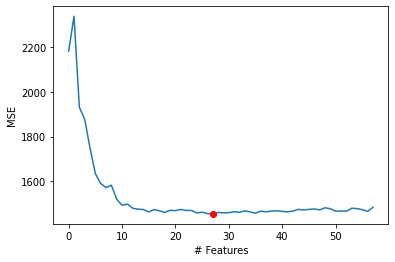

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(models_bwd_2_total["MSE"].sort_index(ascending=False)))
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(57-models_bwd_2_total["MSE"].idxmin(),models_bwd_2_total["MSE"].min(),"or")

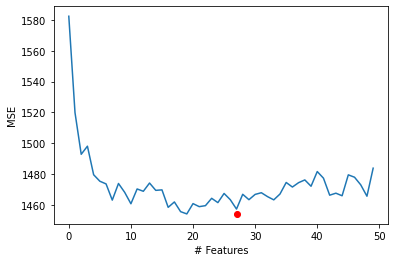

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(models_bwd_2_total["MSE"][:50].sort_index(ascending=False)))
plt.xlabel('# Features')
plt.ylabel('MSE')
plt.plot(57-models_bwd_2_total["MSE"][:50].idxmin(),models_bwd_2_total["MSE"][:50].min(),"or")

## Final Hyperparameter tuning

In [ ]:
from sklearn.tree import DecisionTreeRegressor

adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),random_state=42)

pgrid_initial_5 = {'base_estimator__max_depth':[1,5,10,15,20],
              'base_estimator__min_samples_leaf':[1,3,5,10],
              'n_estimators':[50,100,150,200,250,300],
              'learning_rate':[0.001,0.01,0.1,1]}

grid_search_raw_5 = GridSearchCV(adaboost,param_grid=pgrid_initial_5,cv=5, verbose=11)
grid_search_raw_5.fit(X_train_processed[eval(best_feature_bwd_1)],y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV 1/5; 1/480] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.001, n_estimators=50
[CV 1/5; 1/480] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.001, n_estimators=50;, score=0.147 total time=   1.2s
[CV 2/5; 1/480] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.001, n_estimators=50
[CV 2/5; 1/480] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.001, n_estimators=50;, score=0.212 total time=   1.2s
[CV 3/5; 1/480] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.001, n_estimators=50
[CV 3/5; 1/480] END base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rate=0.001, n_estimators=50;, score=0.156 total time=   0.9s
[CV 4/5; 1/480] START base_estimator__max_depth=1, base_estimator__min_samples_leaf=1, learning_rat

GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                         random_state=42),
             param_grid={'base_estimator__max_depth': [1, 5, 10, 15, 20],
                         'base_estimator__min_samples_leaf': [1, 3, 5, 10],
                         'learning_rate': [0.001, 0.01, 0.1, 1],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             verbose=11)

In [ ]:
print('Best learning rate:', grid_search_raw_5.best_estimator_.get_params()['learning_rate'])
print('Best number of estimators:', grid_search_raw_5.best_estimator_.get_params()['n_estimators'])
print('Besy max depth:', grid_search_raw_5.best_estimator_.get_params()['base_estimator__max_depth'])
print('Best min sample leaf:', grid_search_raw_5.best_estimator_.get_params()['base_estimator__min_samples_leaf'])
print('Accuracy: ', grid_search_raw_5.best_score_ * 100)

Best learning rate: 0.001
Best number of estimators: 200
Besy max depth: 10
Best min sample leaf: 10
Accuracy:  37.367399965491366


In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=10,min_samples_leaf=10)
adaboost = AdaBoostRegressor(base_estimator=tree,learning_rate=0.001,n_estimators=200)

adaboost.fit(X_train_processed[eval(best_feature_bwd_1)],y_train)
preds = adaboost.predict(X_test_processed[eval(best_feature_bwd_1)])

from sklearn.metrics import mean_squared_error

mean_squared_error(y_true=y_test,y_pred=preds)


1085.5620222747134

In [ ]:
np.sqrt(1085.5620222747134)

32.947868250840045

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(y_true=y_test,y_pred=preds)

n = len(y_test)
p = len(eval(best_feature_bwd_1))

r2_adjusted = 1-(1-r2)*(n-1)/(n-p)

print('MAE: ', mean_absolute_error(y_true=y_test,y_pred=preds))
print('Adjusted r sqaured: ', r2_adjusted)



MAE:  19.39039874295492
Adjusted r sqaured:  0.4468909168936599
